# Training Recurrent Neural Networks on Financial Time Series

### Initialize Logger

In [1]:
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### Hyper-Parameters

In [2]:
unrolls = 50       # number of time steps used when making a prediction

batch_size = 1     # number of examples used when updating parameters

num_epochs = 10    # number of times through dataset

reset_period = 100 # number of time steps after which gradient is reset

hidden_units = 128 # size of the hidden layer of the network

features = 13      # End of day open, high, low, close and volume, 
                   # dividends and splits, and split/dividend 
                   # adjusted open, high, low close and volume
                   # 10 day momentum (based of unadjusted open)
                   # NOTE: these are normalized from 0 to 1

### Initialize Backend

In [3]:
from neon.backends import gen_backend
backend = gen_backend(rng_seed=0) # defaults to CPU

INFO:neon.util.compat:using xrange as range
INFO:neon.backends.cpu:Seeding random number generator with: 0
INFO:neon.backends:CPU backend, RNG seed: 0, numerr: None


### Load Dataset

In [4]:
from neon.datasets import StockPrice
dataset = StockPrice(repo_path='~/data',
                   data_dim=features,
                   batch_size=batch_size,
                   unrolls=unrolls,
                   backend=backend)

INFO:neon.datasets.stockprice:Setting dtype to<type 'numpy.float32'>


### Initialize Weights

In [5]:
from neon.params import *
weight_init = NormalValGen(loc=0.0, scale=0.1, bias_init=1.0)
b_init = NormalValGen(loc=0.0, scale=0.1, bias_init=1.0)
lrule_init = {'type': 'gradient_descent',
              'lr_params': {'learning_rate': 0.001}}

### Initialize Layers

In [6]:
from neon.layers import *
from neon.transforms import *
layers = [
    DataLayer(nout=features,
              dataset=dataset),
    RecurrentHiddenLayer(nout=hidden_units,
                         activation=Tanh(),
                         unrolls=unrolls,
                         weight_init=weight_init,
                         weight_init_rec=weight_init,
                         lrule_init=lrule_init),
    RecurrentOutputLayer(nout=features,
                         activation=Logistic(),
                         unrolls=unrolls,
                         weight_init=weight_init,
                         brule_init=lrule_init,
                         lrule_init=lrule_init),
    RecurrentCostLayer(cost=SumSquaredDiffs())
]

INFO:neon.layers.layer:Setting layer dtype to<type 'numpy.float32'>
INFO:neon.layers.layer:Setting layer dtype to<type 'numpy.float32'>
INFO:neon.layers.layer:Setting layer dtype to<type 'numpy.float32'>
INFO:neon.transforms.cost:Setting dtype to<type 'numpy.float32'>
INFO:neon.layers.layer:Setting layer dtype to<type 'numpy.float32'>


### Initialize Model

In [7]:
from neon.models import RNN
rnn = RNN(layers=layers,
          batch_size=batch_size,
          unrolls=unrolls,
          backend=backend,
          num_epochs=num_epochs,
          reset_period=reset_period,
          truncate=True,
          make_plots=False)

### Train Model

In [8]:
from neon.experiments import FitPredictErrorExperiment
experiement = FitPredictErrorExperiment(model=rnn,
                                        dataset=dataset,
                                        backend=backend)
experiement.run()

INFO:neon.params.val_init:Generating GaussianValGen values of shape (128, 13)
INFO:neon.params.val_init:Generating GaussianValGen values of shape (128, 128)
INFO:neon.params.val_init:Generating GaussianValGen values of shape (13, 128)
INFO:neon.datasets.stockprice:loading: AAPL.csv
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
INFO:neon.models.mlp:Layers:
	DataLayer layer: 13 nodes
	RecurrentHiddenLayer layer: 13 inputs, 128 nodes, Tanh act_fn
	RecurrentOutputLayer layer: 128 inputs, 13 nodes, Logistic act_fn
	Layer layer: 13 nodes, SumSquaredDiffs cost_fn, utilizing CPU backend
	

INFO:neon.models.rnn:commencing model fitting
INFO:neon.models.rnn:epoch: 1, total training error: 0.15424
INFO:neon.models.rnn:epo

{'test': {'MisclassPercentage_TOP_1': 46.375},
 'train': {'MisclassPercentage_TOP_1': 4.640625}}

### Plot Predictions

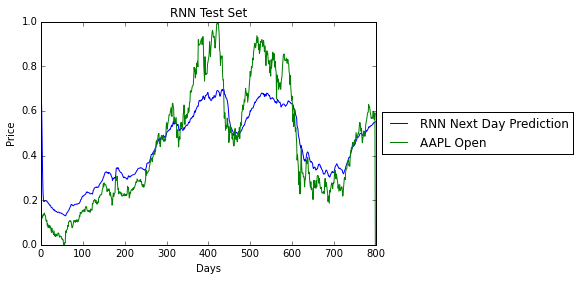

In [10]:
import numpy as np
predicted = np.loadtxt('test-pred.txt')
actual = np.loadtxt('test-true.txt')

from matplotlib import pyplot as plt
plt.plot(predicted.T[:, 0], label='RNN Next Day Prediction')
plt.plot(actual.T[:, 0], label='AAPL Open')
plt.title('RNN Test Set')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()